# Finance Dashboard 

## 0. Import libraries

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# import streamlit as st

In [ ]:
import FinanceDataReader as fdr
import quantstats as qs

In [ ]:
## custom libs

from korquanttools.pricevolume.loader import KRXPriceDM
from korquanttools.pricevolume.utils import DateUtil
from korquanttools.pricevolume.config import PathConfig

In [ ]:
import json
import pickle

In [ ]:
from tqdm import tqdm

## 1. Import data

- Import price-volume data from KRX using custom lib `korquanttools.pricevolume`

In [ ]:
# Global parameters

START = 20140101
# START = 20210101
END = 20220520

In [ ]:
pricevolume = KRXPriceDM(START, END)

In [ ]:
pricevolume.get_info()

In [ ]:
# Download price-volume data from KRX.
# Also, build cache for faster access. (Both lv1 and lv2)

close_df = pricevolume.get_data("close")

In [ ]:
close_df

In [ ]:
close_df.loc[:, '005930'] # 삼성전자. 
# 분할했었기 때문에 가격이 100만원 대에서 6만원 대로 변한다. 

In [ ]:
volume_df = pricevolume.get_data('volume')
dollarvolume_df = pricevolume.get_data('dollarvolume')
marketcap_df = pricevolume.get_data('marketcap') # TODO: 현재 object로 불러와져 직접 astype(float) 해줘야 함. fix it. 

In [ ]:
volume_df

In [ ]:
volume_df.loc[:, '005930'] # 삼성전자
# volume 역시 unadjusted volume이다. 

## 2. Create additional DMs


- KOSPI, KOSDAQ

In [ ]:
lv1_df = pricevolume.get_data('lv1')

In [ ]:
market_cat_df = lv1_df[['ISU_SRT_CD', 'MKT_NM', 'trdDd']].copy()

In [ ]:
market_cat_df['MKT_NM'].unique()

In [ ]:
market_cat_df.loc[:, 'is_KOSPI'] = (market_cat_df['MKT_NM'] == 'KOSPI')
market_cat_df.loc[:, 'is_KOSDAQ'] = (market_cat_df['MKT_NM'] == 'KOSDAQ')
market_cat_df.loc[:, 'is_KONEX'] = (market_cat_df['MKT_NM'] == 'KONEX')

In [ ]:
kospi_univ_df = pd.pivot(market_cat_df, index='trdDd', columns='ISU_SRT_CD', values='is_KOSPI')
kosdaq_univ_df = pd.pivot(market_cat_df, index='trdDd', columns='ISU_SRT_CD', values='is_KOSDAQ')
konex_univ_df = pd.pivot(market_cat_df, index='trdDd', columns='ISU_SRT_CD', values='is_KONEX')

In [ ]:
kosdaq_univ_df.loc[:, '221610'] # 자안바이오 상폐일: 2022-01-05	


- tradingday DM by processing `pricevolume`


In [ ]:
holidays = close_df.isnull().all(axis=1)
tradingdays = ~holidays

holidays = holidays.index[holidays]
tradingdays = tradingdays.index[tradingdays]

tradingdays


- return & adj.open/high/low/close/volume DM by mixing `pricevolume` and `FinanceDataReader`


In [ ]:
universe_df = close_df.notnull()
universe_df

In [ ]:
# # Takes about 20 mins

# adjOpen_df = close_df.copy()
# adjHigh_df = close_df.copy()
# adjLow_df = close_df.copy()
# adjClose_df = close_df.copy()
# adjVolume_df = close_df.copy()
# return_df = close_df.copy()

# for ii in tqdm(close_df.columns):
#     ii_df = fdr.DataReader(ii, DateUtil.numdate2stddate(START), DateUtil.numdate2stddate(END))

#     adjOpen_df.loc[:, ii] = ii_df['Open']
#     adjHigh_df.loc[:, ii] = ii_df['High']
#     adjLow_df.loc[:, ii] = ii_df['Low']
#     adjClose_df.loc[:, ii] = ii_df['Close']
#     adjVolume_df.loc[:, ii] = ii_df['Volume']
#     return_df.loc[:, ii] = ii_df['Change']
    

In [ ]:
# adjOpen_df.to_pickle(PathConfig.cache_path / f"temp_adjOpen_{START}_{END}")
# adjHigh_df.to_pickle(PathConfig.cache_path / f"temp_adjHigh_{START}_{END}")
# adjLow_df.to_pickle(PathConfig.cache_path / f"temp_adjLow_{START}_{END}")
# adjClose_df.to_pickle(PathConfig.cache_path / f"temp_adjClose_{START}_{END}")
# adjVolume_df.to_pickle(PathConfig.cache_path / f"temp_adjVolume_{START}_{END}")
# return_df.to_pickle(PathConfig.cache_path / f"temp_return_{START}_{END}")

In [ ]:
PathConfig.cache_path

In [ ]:
adjOpen_df = pd.read_pickle(PathConfig.cache_path / f"temp_adjOpen_{START}_{END}")
adjHigh_df = pd.read_pickle(PathConfig.cache_path / f"temp_adjHigh_{START}_{END}")
adjLow_df = pd.read_pickle(PathConfig.cache_path / f"temp_adjLow_{START}_{END}")
adjClose_df = pd.read_pickle(PathConfig.cache_path / f"temp_adjClose_{START}_{END}")
adjVolume_df = pd.read_pickle(PathConfig.cache_path / f"temp_adjVolume_{START}_{END}")
return_df = pd.read_pickle(PathConfig.cache_path / f"temp_return_{START}_{END}")


### (Skip for now) Download additional data for new DMs 

- KRX sector DM downloaded from KRX
    - NOT PIT(Point-In-Time)
- Corporate finance fundamental analysis data from DART (using 3rd party libraries)
    - Later on, when I need it

In [101]:
fdr.__version__

'0.9.33'

In [ ]:
kospi_index_df = fdr.DataReader('KS11', DateUtil.numdate2stddate(START), DateUtil.numdate2stddate(END))

In [ ]:
kospi_index_df

In [ ]:
kospi_firstday_value = kospi_index_df['Close'].iloc[0]
kospi_firstday_value

<AxesSubplot:xlabel='Date'>

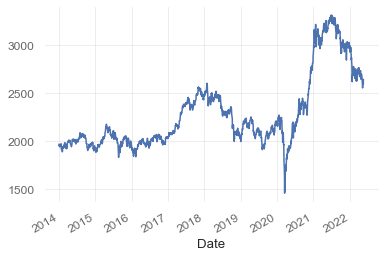

In [117]:
kospi_index_df['Close'].plot()

In [ ]:
kospi_adjClose_df = adjClose_df[kospi_univ_df]
kospi_marketcap_df = marketcap_df[kospi_univ_df]

In [ ]:
kospi_adjClose_df = kospi_adjClose_df.loc[tradingdays, :]
kospi_marketcap_df = kospi_marketcap_df.loc[tradingdays, :]

In [111]:
kospi_marketcap_df = kospi_marketcap_df.astype(float)

In [112]:
kospi_marketcap_df


ISU_SRT_CD,000020,000040,000050,000060,000070,000075,000080,000087,000100,000105,...,37550L,388050,389140,405640,412930,413600,415580,419270,389260,399720
trdDd,,,,,,,,,,,,,,,,,,,,,
2014-01-02,1.240157e+11,5.227152e+10,2.778912e+11,1.570596e+12,6.005292e+11,9.912291e+09,1.525406e+12,1.904283e+10,2.035340e+12,2.203634e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,1.268089e+11,5.251021e+10,2.841220e+11,1.560464e+12,5.866394e+11,1.015554e+10,1.504366e+12,1.904283e+10,2.013035e+12,2.196548e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,1.272278e+11,5.251021e+10,2.903527e+11,1.555397e+12,5.939928e+11,1.015554e+10,1.521899e+12,1.853426e+10,2.096679e+12,2.201272e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,1.279261e+11,5.239087e+10,2.903527e+11,1.560464e+12,6.037974e+11,1.010993e+10,1.521899e+12,1.870378e+10,2.197052e+12,2.236700e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-08,1.321159e+11,5.298757e+10,2.841220e+11,1.560464e+12,6.013462e+11,9.881885e+09,1.511379e+12,1.853426e+10,2.230509e+12,2.231977e+10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-16,3.309879e+11,7.604487e+10,4.263074e+11,4.505344e+12,6.997009e+11,1.912525e+10,2.514290e+12,2.373290e+10,4.232779e+12,6.707739e+10,...,8.490043e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-17,3.323845e+11,7.575645e+10,4.235659e+11,4.613906e+12,7.005574e+11,1.912525e+10,2.591437e+12,2.395893e+10,4.232779e+12,6.695930e+10,...,8.490043e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-05-18,3.351776e+11,7.527577e+10,4.167121e+11,4.794844e+12,6.954188e+11,1.915565e+10,2.580917e+12,2.390242e+10,4.291364e+12,6.743167e+10,...,8.373886e+10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
kospi_calculated = (kospi_adjClose_df * kospi_marketcap_df).sum(axis=1)
normalize_coef = kospi_firstday_value / kospi_calculated.iloc[0]
kospi_calculated = kospi_calculated * normalize_coef
kospi_calculated

trdDd
2014-01-02    1967.190000
2014-01-03    1921.005495
2014-01-06    1936.754471
2014-01-07    1945.329104
2014-01-08    1939.517307
                 ...     
2022-05-16    5010.947855
2022-05-17    5082.646497
2022-05-18    5178.122050
2022-05-19    5084.969102
2022-05-20       0.000000
Length: 2062, dtype: float64

<AxesSubplot:xlabel='trdDd'>

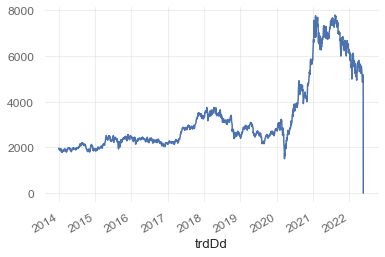

In [116]:
kospi_calculated.plot()

<AxesSubplot:xlabel='Date'>

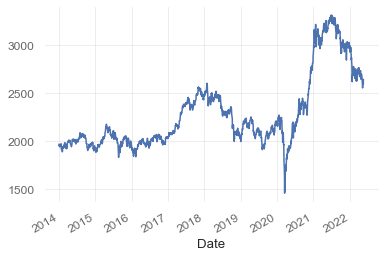

In [ ]:
kospi_index_df['Close'].plot()

아래는 잠시 우리은행꺼. 

In [ ]:
# kospi_ii_l = kospi_univ_df.columns
# kospi_ii2dates = {}

# for ii in kospi_ii_l:
#     dates = kospi_univ_df[ii].index[kospi_univ_df[ii].fillna(False)]
#     if len(dates) > 0:
#         kospi_ii2dates[ii] = dates

In [ ]:
# kosdaq_ii_l = kosdaq_univ_df.columns
# kosdaq_ii2dates = {}

# for ii in kosdaq_ii_l:
#     dates = kosdaq_univ_df[ii].index[kosdaq_univ_df[ii].fillna(False)]
#     if len(dates) > 0:
#         kosdaq_ii2dates[ii] = dates

In [ ]:
# pickle.dump(kospi_ii2dates, open('kospi_ii2dates.pickle','wb'))
# pickle.dump(kosdaq_ii2dates, open('kosdaq_ii2dates.pickle', 'wb'))

## 3. Make price-volume chart graph

- Simple price-volume chart using both `seaborn`/`streamlit`
- Show biggest winners/losers on mouse hover
    - Make pseudo-KOSPI portfolio mimicking KOSPI index
    - Show Top 3 winners/losers on the graph 

In [ ]:
sns.

## 4. Make Finviz-style stock tree map

## 5. Make return correlation clustering DM 

- Also, visualize the result

## 6. Create NLP news DM